<h1><center><font size="6">Diabetes Detection</font></center></h1>

# Outline
- [Import necessary Libraries](#1)
- [Introduction](#2)
- [Exploratory data analysis](#3)
- [Data preprocessing](#4)
    - [Handling missing values](#4.1)
    - [Handling outliers](#4.2)
    - [Scaling the data](#4.3)
    - [Splitting the data](#4.4)
- [Model building](#5)
- [Training the model](#6)
- [Result analysis](#7)
    - [Loss function](#7.1)
    - [Training/Validation accuracy](#7.2)
    - [Accuracy](#7.3)
    - [Further improvements](#7.4)
- [References](#8)

<a id='1'></a>
# Import necessary Libraries

In [1]:
# Import necessary libraries and print their versions
from platform import python_version
print(f"Python: {python_version()}")
import numpy as np
print(f"Numpy: {np.__version__}")
import pandas as pd
print(f"Pandas: {pd.__version__}")
import tensorflow as tf
print(f"Tensorflow: {tf.__version__}")
import sklearn
print(f"Scikit-Learn: {sklearn.__version__}")
from sklearn.model_selection import train_test_split
import mlxtend
print(f"mlxtend: {mlxtend.__version__}")
from mlxtend.preprocessing import minmax_scaling
import seaborn as sns
print(f"Seaborn: {sns.__version__}")
import matplotlib
print(f"Matplotlib: {matplotlib.__version__}")
import matplotlib.pyplot as plt
%matplotlib inline

Python: 3.9.16
Numpy: 1.24.1
Pandas: 1.5.2
Tensorflow: 2.10.1
Scikit-Learn: 1.2.0
mlxtend: 0.21.0
Seaborn: 0.12.2
Matplotlib: 3.6.3


<a id='2'></a>
# Introduction
Diabetes is a chronic disease associated with elevated blood glucose levels in the body. Diabetes often leads to cardiovascular disease, stroke, kidney damage and long-term damage to the extremities (i.e. limbs and eyes). One of the barriers to early detection and diagnosis of diabetes is that the early stages of diabetes often have no symptoms. People who are on the path to diabetes (pre-diabetes) often do not know they have diabetes until it is too late. In this project, we will use deep learning to solve this problem. We have a labelled dataset that contains some vital signs of patients who have developed diabetes after measurement. With this data, we can train a neural network and use it to make predictions about new patients. The data we will use for this project is from the Pima Indian Diabetes dataset. This consists of diagnostic measurements collected from a sample of Pima Indian females, along with a label indicating whether the patient developed diabetes within five years of the first measurement.

The flow chart below shows the individual steps of the project:

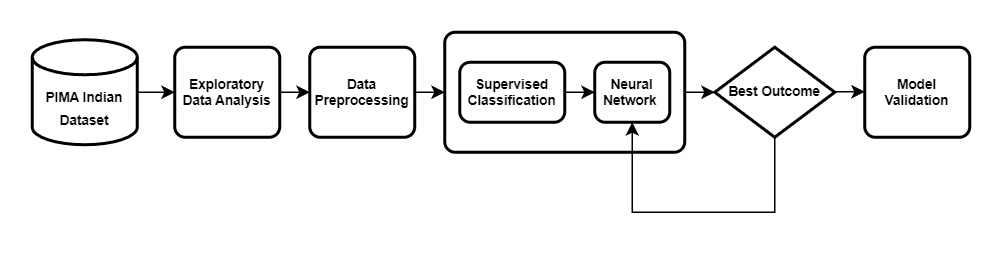

In the next section, we will conduct an exploratory data analysis of the dataset to gain important insights into the data.

<a id='3'></a>
# Exploratory data analysis

In [2]:
# Import data
data = pd.read_csv("../data/diabetes.csv")
# Take a quick look at the first five rows of the dataset
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


The data set consists of nine columns, which are as follows:
- **Pregnancies**: Number of previous pregnancies
- **Glucose**: Plasma glucose concentration
- **BloodPressure**: Diastolic blood pressure
- **SkinThickness**: Skin fold thickness measured from the triceps
- **Insulin**: Blood serum insulin
- **BMI**: Body mass index
- **DiabetesPedigreeFunction**: A summarized score that indicates the genetic predisposition of the patient for diabetes, as extrapolated from the patient's family record for diabetes
- **Age**: Age in years
- **Outcome**: The target variable we are trying to predict, **1** for patients that developed diabetes within five years of the initial measurement, and **0** otherwise

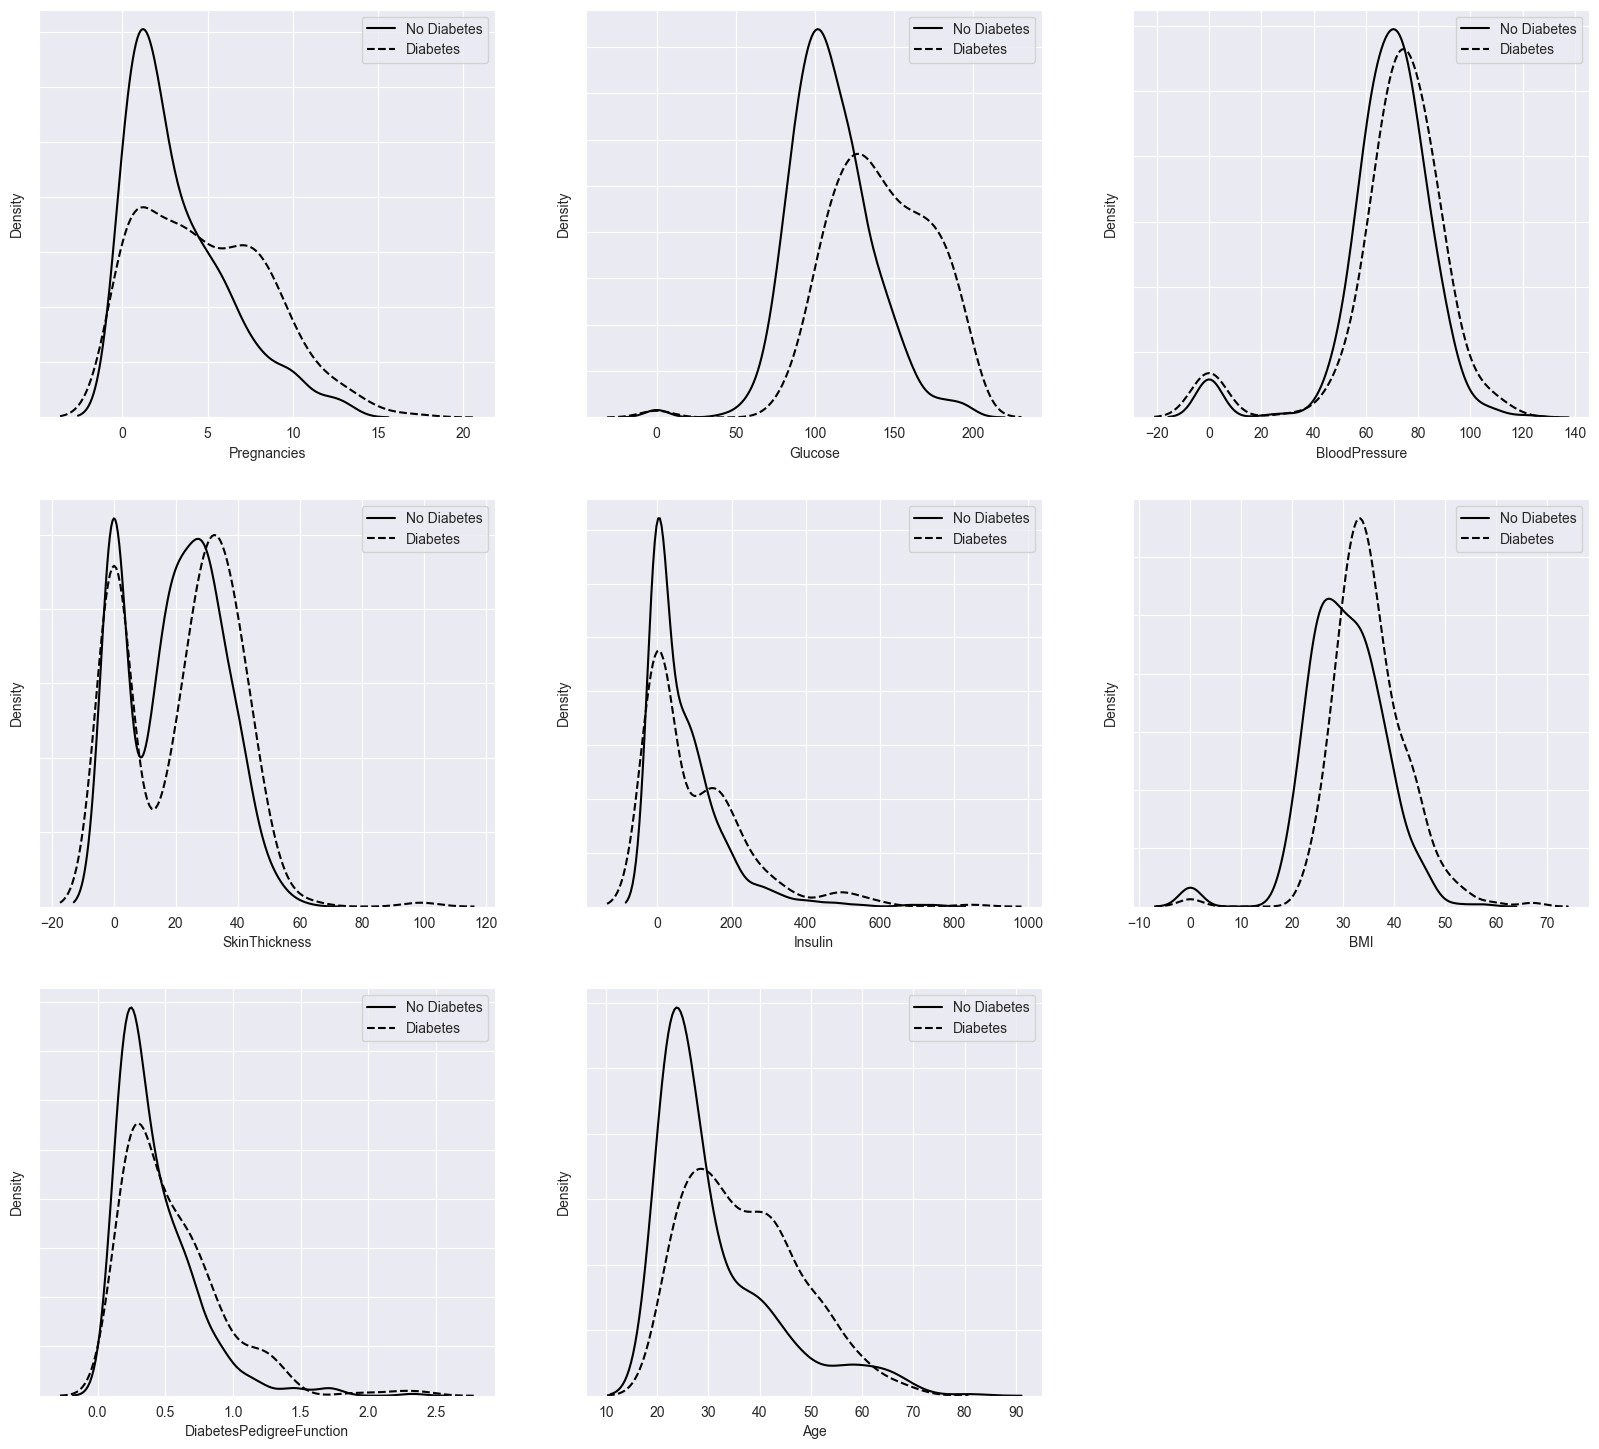

In [3]:
# Create a subplot of 3x3
plt.subplots(3, 3, figsize=(20, 18))
# Plot a density plot for each variable
for idx, col in enumerate(data.columns):
    ax = plt.subplot(3, 3, idx + 1)
    ax.yaxis.set_ticklabels([])
    sns.kdeplot(data.loc[data.Outcome == 0][col], warn_singular=False, color="black")
    sns.kdeplot(
        data.loc[data.Outcome == 1][col],
        warn_singular=False,
        color="black",
        linestyle="dashed",
    )
    ax.legend(["No Diabetes", "Diabetes"])
# Hide the 9th subplot since it is the prediction column
plt.subplot(3, 3, 9).set_visible(False)
plt.show()

Let's look at the individual charts to see what insights we can gain:
- **Glucose**: For the non-diabetics (solid line), the curve shows a normal distribution centred around the 100 mark. This means that most non-diabetics have a blood glucose value of **100 mg/dL**. On the other hand, if we look at diabetics (dashed line), the curve is wider and centred around the 150 mark. This suggests that diabetics tend to have a wider variation in blood glucose, and the average blood glucose level is **159 mg/dL**. So there is a significant difference between the blood glucose levels of diabetics and non-diabetics.
- **BMI, age**: Just as with the variable **glucose**, the same phenomenon can be observed with the variables **BMI** and **age**. In other words: **glucose, BMI** and **age** are strong predictors of diabetes. People with diabetes tend to have higher blood glucose levels, higher BMI and are more likely to be older.
- **Blood pressure, skin thickness**: Looking at these graphs, we can see that there are significant differences in the distribution between diabetics and non-diabetics for variables such as **blood pressure** and **skin thickness**. The two groups of people tend to have similar blood pressure and skin thickness values and are therefore poorer indicators of diabetes.

<a id='4'></a>
# Data preprocessing
<a id='4.1'></a>
## Handling missing values

In [4]:
# Convert all variable names to lower case letters
data.columns = map(str.lower, data.columns)

In [5]:
# Check statistical summary of the data
data.describe()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age,outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [6]:
# Check for missing values
data.isnull().sum()

pregnancies                 0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
outcome                     0
dtype: int64

In [7]:
# Replace zeros with NaN values
columns_with_null = ["glucose", "bloodpressure", "skinthickness", "insulin", "bmi"]
for variable in columns_with_null:
    data[variable] = data[variable].replace(0, np.NaN)

In [8]:
# Check for missing values
data.isnull().sum()

pregnancies                   0
glucose                       5
bloodpressure                35
skinthickness               227
insulin                     374
bmi                          11
diabetespedigreefunction      0
age                           0
outcome                       0
dtype: int64

In [9]:
def median_target(data, variable):
    """
    Determines the median of a variable in relation to the target variable

    Parameters
    ----------
    data: pandas Dataframe
        Dataframe containing the relevant data
    variable: string
        Variable for which the median is to be determined
    Returns
    -------
    Spits out a dataframe with the median for the different results of the target variable
    """
    relevant_data = data[data[variable].notnull()]
    target = (
        relevant_data[[variable, "outcome"]]
        .groupby(["outcome"])[[variable]]
        .median()
        .reset_index()
    )
    return target

In [10]:
# Replace NaN values with the median
# Replace the bull values in each column with corresponding median
def replace(data, columns):
    """
    Replaces the null values in a given column with the corresponding median

    Parameters
    ----------
    data: pandas Dataframe
        Dataframe containing the relevant data
    columns: list
        List of columns for which the null values are to be filled in

    Returns
    -------
    Returns the input dataframe with replaced null values. Also gives a print statement for each column with the median in relation to the target variable
    """
    for variable in columns:
        median = median_target(data, variable)
        print(median)
        data.loc[(data["outcome"] == 0) & (data[variable].isnull()), variable] = median[
            [variable]
        ].values[0][0]
        data.loc[(data["outcome"] == 1) & (data[variable].isnull()), variable] = median[
            [variable]
        ].values[1][0]

In [11]:
replace(data, columns_with_null)

   outcome  glucose
0        0    107.0
1        1    140.0
   outcome  bloodpressure
0        0           70.0
1        1           74.5
   outcome  skinthickness
0        0           27.0
1        1           32.0
   outcome  insulin
0        0    102.5
1        1    169.5
   outcome   bmi
0        0  30.1
1        1  34.3


In [12]:
# Check if everything worked correctly
data.isnull().sum()

pregnancies                 0
glucose                     0
bloodpressure               0
skinthickness               0
insulin                     0
bmi                         0
diabetespedigreefunction    0
age                         0
outcome                     0
dtype: int64

<a id='4.2'></a>
## Handling outliers

In [13]:
def remove_outliers(data, variable):
    """
    Cleans up the outliers for a given column in a dataframe

    Parameters
    ----------
    data: pandas Dataframe
        Dataframe containing the relevant data
    variable: str
        Column for which the outliers are to be adjusted
    Returns
    -------
    Returns a cleaned dataframe with outliers corrected for the given column. In addition, there is a print statement showing the number of outliers and their values as well as information about the number of new values and variables in the cleaned dataframe.
    """
    value_variabel = data[variable]
    # Q1 (25th percentile) for the given variable
    q1 = np.percentile(value_variabel, 25.0)
    # Q3 (75th percentile) for the given variable
    q3 = np.percentile(value_variabel, 75.0)
    # Multiply the interquartile range (IQR) by 1.5 (a constant used to discern outliers)
    step = 1.5 * (q3 - q1)
    # Specify outliers in data
    outliers = value_variabel[
        ~((value_variabel >= q1 - step) & (value_variabel <= q3 + step))
    ].index.tolist()
    # Sepcify the value of the outliers
    value_outliers = value_variabel[
        ~((value_variabel >= q1 - step) & (value_variabel <= q3 + step))
    ].values
    # Remove outliers
    print(f"Number of outliers is {len(outliers)} and their value is {value_outliers}")
    cleaned_data = data.drop(data.index[outliers]).reset_index(drop=True)
    print(
        f"Cleaned dataset with removed outliers has now {cleaned_data.shape[0]} samples with {cleaned_data.shape[1]} variables each."
    )
    return cleaned_data

In [14]:
data_clean = remove_outliers(data, "pregnancies")

Number of outliers is 4 and their value is [15 17 14 14]
Cleaned dataset with removed outliers has now 764 samples with 9 variables each.


In [15]:
data_clean = remove_outliers(data_clean, "glucose")

Number of outliers is 0 and their value is []
Cleaned dataset with removed outliers has now 764 samples with 9 variables each.


In [16]:
data_clean = remove_outliers(data_clean, "bloodpressure")

Number of outliers is 14 and their value is [ 30. 110. 108. 122.  30. 110. 108. 110.  24.  38. 106. 106. 106. 114.]
Cleaned dataset with removed outliers has now 750 samples with 9 variables each.


In [17]:
data_clean = remove_outliers(data_clean, "skinthickness")

Number of outliers is 85 and their value is [45. 47. 11. 47. 11. 10. 60. 13. 13. 54. 51. 56. 14. 13. 50. 44. 12. 44.
 13. 44. 54. 14.  7. 50. 52. 10. 44. 43. 45. 14. 10. 11. 12. 43. 13. 12.
 48. 43. 43.  8. 13. 14. 12. 49. 46. 46. 11.  8. 12. 63. 12. 45. 13. 48.
 13. 10. 45.  7. 52. 49. 43. 14. 47. 99. 46. 11. 50. 45. 14. 13. 13. 47.
 12. 48. 43. 46. 45. 10. 46. 49. 11. 13. 46. 44. 48.]
Cleaned dataset with removed outliers has now 665 samples with 9 variables each.


In [18]:
data_clean = remove_outliers(data_clean, "insulin")

Number of outliers is 41 and their value is [846. 300. 342. 304. 495. 325. 284. 485. 285. 495. 318. 280. 271. 478.
 744. 370. 680. 402. 375. 360. 325. 293. 285. 275. 310. 474. 277. 328.
 480. 274. 330. 600. 293. 272. 321. 440. 540. 480. 335. 291. 392.]
Cleaned dataset with removed outliers has now 624 samples with 9 variables each.


In [19]:
data_clean = remove_outliers(data_clean, "bmi")

Number of outliers is 6 and their value is [52.3 52.9 48.3 57.3 49.6 49.3]
Cleaned dataset with removed outliers has now 618 samples with 9 variables each.


In [20]:
data_clean = remove_outliers(data_clean, "diabetespedigreefunction")

Number of outliers is 27 and their value is [2.288 1.441 1.893 1.781 1.222 1.4   1.189 1.321 1.224 1.318 1.213 1.353
 1.224 1.391 1.476 1.731 1.268 1.191 1.159 1.251 1.699 1.282 1.698 1.461
 1.292 1.174 1.182]
Cleaned dataset with removed outliers has now 591 samples with 9 variables each.


In [21]:
data_clean = remove_outliers(data_clean, "age")

Number of outliers is 9 and their value is [69 67 72 81 67 67 70 68 69]
Cleaned dataset with removed outliers has now 582 samples with 9 variables each.


In [22]:
print(f"Original shape {data.shape}, new shape of the cleaned data {data_clean.shape}")

Original shape (768, 9), new shape of the cleaned data (582, 9)


<a id='4.3'></a>
## Splitting the data
- **Training set**: The neural network is trained on this subset of the data.
- **Validation set**: This data set allows us to tune the hyperparameters using an unbiased data source.
- **Test set**: The final evaluation of the neural network is based on this subset.

The purpose of splitting the data into training, testing and validation sets is to avoid overfitting and to provide an unbiased data source for evaluating model performance. The validation set can be used to stop training early, i.e. we train our model only up to the point where performance on the validation set no longer improves. In this way, overfitting of the neural network can be avoided. The test set is also called the holdout set because the neural network is never trained with this set. Instead, we use the test set to evaluate the model at the end. This way we get an accurate picture of the real performance of our model.


In [23]:
# Check the balance of the target variable
data_clean["outcome"].value_counts()

0    396
1    186
Name: outcome, dtype: int64

In [24]:
# Data splitting
X = data_clean.drop("outcome", axis=1)
y = data_clean["outcome"]
# Splitting into train and test set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, shuffle=True, random_state=42
)
# Splitting into train and validation set
X_train, X_val, y_train, y_val = train_test_split(
    X_train, y_train, test_size=0.25, stratify=y_train, shuffle=True, random_state=42
)
# Size of the different set
print(
    f"Size of the training set: {(X_train.shape,y_train.shape)}\n"
    f"Size of the training set: {(X_val.shape,y_val.shape)}\n"
    f"Size of the testing set: {(X_test.shape,y_test.shape)}"
)

Size of the training set: ((348, 8), (348,))
Size of the training set: ((117, 8), (117,))
Size of the testing set: ((117, 8), (117,))


<a id='4.4'></a>
## Scaling the data
Scaling is another important technique in data preprocessing. An alternative approach to Z-score normalization (or standardization) is so-called min-max scaling (often simply called "normalization"). In this approach, data are scaled to a fixed range - here 0 to 1. The price for this limited range - in contrast to standardization - is that we end up with smaller standard deviations, which can suppress the effect of outliers. A Min-Max scaling is typically done via the following equation:
$$ X_{sc} = \frac{X - X_{min}}{X_{max} - X_{min}} $$

In [25]:
# Scaling the training set
X_train = minmax_scaling(
    X_train,
    columns=[
        "pregnancies",
        "glucose",
        "bloodpressure",
        "skinthickness",
        "insulin",
        "bmi",
        "diabetespedigreefunction",
        "age",
    ],
)
# Check if everything worked correctly
X_train.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age
394,1.000000,0.210526,0.266667,0.444444,0.335317,0.491582,0.094796,0.444444
539,0.307692,0.256579,0.700000,0.148148,0.335317,0.373737,0.222119,0.288889
8,0.307692,0.434211,0.800000,0.444444,0.335317,0.653199,0.105019,0.200000
136,0.384615,0.651316,0.566667,0.444444,0.335317,0.902357,0.104089,0.577778
17,0.692308,0.493421,0.600000,0.740741,0.601190,0.363636,0.171933,0.177778


In [26]:
# Scaling the validation set
X_val = minmax_scaling(
    X_val,
    columns=[
        "pregnancies",
        "glucose",
        "bloodpressure",
        "skinthickness",
        "insulin",
        "bmi",
        "diabetespedigreefunction",
        "age",
    ],
)
# Check if everything worked correctly
X_val.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age
553,0.153846,0.330827,0.500000,0.444444,0.434673,0.061475,0.468191,0.711111
555,0.000000,0.488722,0.703704,0.444444,0.522613,0.229508,0.423459,0.000000
176,0.076923,0.135338,0.592593,0.370370,0.105528,0.147541,0.491054,0.022222
528,0.307692,0.368421,0.518519,0.185185,0.422111,0.270492,0.028827,0.133333
47,0.538462,0.398496,0.333333,0.629630,0.771357,0.450820,0.167992,0.466667


In [27]:
# Scaling the test set
X_test = minmax_scaling(
    X_test,
    columns=[
        "pregnancies",
        "glucose",
        "bloodpressure",
        "skinthickness",
        "insulin",
        "bmi",
        "diabetespedigreefunction",
        "age",
    ],
)
# Check if everything worked correctly
X_test.head()

,pregnancies,glucose,bloodpressure,skinthickness,insulin,bmi,diabetespedigreefunction,age
478,0.153846,0.322581,0.266667,0.444444,0.402381,0.284698,0.252976,0.044444
28,0.307692,0.258065,0.266667,0.666667,0.828571,0.206406,0.871032,0.266667
463,0.230769,0.830645,0.233333,0.259259,0.838095,0.523132,0.500992,0.333333
225,0.000000,0.443548,0.666667,0.518519,0.938095,0.444840,0.428571,0.066667
12,0.538462,0.290323,0.500000,0.629630,0.721429,0.405694,0.164683,0.222222


<a id='5'></a>
# Model building
With the data preprocessing, we can create our end-to-end model.
## Model architecture
With Keras, we can build a neural network like a Lego set by stacking layers on top of each other. The first hidden layer has 100 nodes and the input dimensions are 8 (because there are 8 columns in **X_train**). Note that we need to specify the input dimensions for the first hidden layer. Then Keras automatically takes care of the size compatibility of the other hidden layers. The **activation** function used is **relu**. After that, you will come across a regularisation parameter called **tf.keras.regularizers.l1()**. We use regularisation because we want to add some bias to our model to prevent it from over-fitting our training data. After implementing regularisation, we have a machine learning model that performs well on the training data and has a good ability to generalise to new examples that it did not see during training. **L1 regularisation** and **L2 regularisation** are two popular regularisation techniques to combat the overfitting problem. If you want to learn more about them and get an idea of how they work, you can read about them [here.](https://medium.com/analytics-vidhya/regularization-understanding-l1-and-l2-regularization-for-deep-learning-a7b9e4a409bf) It should also be noted that we have arbitrarily set the number of nodes for the first hidden layer. This variable is a hyperparameter that should be carefully chosen through trial and error. As mentioned earlier, we will skip hyperparameter tuning in this project and simply use 100 as the initial number of nodes. Further instructions on hyperparameter tuning in Keras can be found [here.](https://keras.io/keras_tuner/) For this project, we will only use one hidden layer, as this is sufficient to create a satisfactory model. Finally, the output layer comes into play. This layer has only a single node, as this is a binary classification. The **activation** function used is the **sigmoid** function, it provides the output between **0** and **1** (binary output).
## Model compilation
Before we start training our model, we need to set the parameters of the training process, which is done with the **compile** method. There are three different parameters that we need to define for the training process:
- **Optimizer**: We will use the **adam** optimizer. For most data sets, the **adam** optimizer will work well without much adjustment.
- **Loss function**: We use **binary_crossentropy** as the **loss function** since the problem is a binary classification problem.
- **Metrics**: We use **accuracy** (i.e. the percentage of correctly classified samples) as the evaluation metric.

In [28]:
# Build model
model = tf.keras.Sequential()
# Add the hidden layer
model.add(
    tf.keras.layers.Dense(
        100,
        activation="relu",
        input_dim=8,
        kernel_regularizer=tf.keras.regularizers.l1(0.01),
    )
)
# Add the output layer
model.add(tf.keras.layers.Dense(1, activation="sigmoid"))
# Compile model
model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])

In [29]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               900       
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 1,001
Trainable params: 1,001
Non-trainable params: 0
_________________________________________________________________


<a id='6'></a>
# Training the model
To train our defined model we will call the **fit** function and train it for **200** epochs. The batch size is a hyperparameter that specifies the number of samples that are run before the internal model parameters are updated. We can think of a batch as a for loop that iterates over one or more samples and makes predictions. At the end of the batch, the predictions are compared to the expected output variables and an error is calculated. Based on this error, the update algorithm is used to improve the model, i.e. to go down along the error gradient. When all training samples are used to create a batch, the learning algorithm is called batch gradient descent. When the batch is the size of a sample, the learning algorithm is called stochastic gradient descent. When the batch size is more than one sample and less than the size of the training dataset, the learning algorithm is called mini-batch gradient descent:
- **Batch Gradient Descent**: Batch size = Size of training set
- **Stochastic Gradient Descent**: Batch size = 1
- **Mini-Batch Gradient Descent**: 1 < Batch size < Size of training set

In the case of the mini-batch gradient descent, 16, 32, 64 and 128 samples are often used. These values are used in models in the literature and tutorials.

In [30]:
# Train model
history = model.fit(
    X_train, y_train, validation_data= (X_val,y_val), batch_size=16, epochs=200, verbose=1
)

Epoch 1/200
22/22 [==============================] - 1s 11ms/step - loss: 1.5433 - accuracy: 0.5891 - val_loss: 1.4472 - val_accuracy: 0.6838
Epoch 2/200
22/22 [==============================] - 0s 4ms/step - loss: 1.3774 - accuracy: 0.6782 - val_loss: 1.2979 - val_accuracy: 0.6838
Epoch 3/200
22/22 [==============================] - 0s 5ms/step - loss: 1.2384 - accuracy: 0.6782 - val_loss: 1.1685 - val_accuracy: 0.6838
Epoch 4/200
22/22 [==============================] - 0s 4ms/step - loss: 1.1156 - accuracy: 0.6782 - val_loss: 1.0527 - val_accuracy: 0.6838
Epoch 5/200
22/22 [==============================] - 0s 5ms/step - loss: 1.0078 - accuracy: 0.6782 - val_loss: 0.9522 - val_accuracy: 0.6838
Epoch 6/200
22/22 [==============================] - 0s 5ms/step - loss: 0.9135 - accuracy: 0.6782 - val_loss: 0.8650 - val_accuracy: 0.6838
Epoch 7/200
22/22 [==============================] - 0s 5ms/step - loss: 0.8341 - accuracy: 0.6782 - val_loss: 0.7953 - val_accuracy: 0.6838
Epoch 8/200


As we can see, the loss decreases and the accuracy increases with each epoch as the learning algorithm continuously updates the weights and biases in the neural network. In the next section we will take a look at the performance of the neural network and some other important metrics.

<a id='7'></a>
# Result analysis
After we have successfully trained our neural network, let's evaluate our model based on accuracy and some graphs.
<a id='7.1'></a>
## Loss function
The first quantity that can be usefully tracked during training is the loss, as it is assessed for each batch during the forward pass. The loss of the model will almost always be lower on the training data set than on the validation data set. This means that we should expect some gap between the learning curves for the training loss and the test loss. This gap is called the "generalization gap". Below is a plot showing the loss of our model over time. The plot of the loss function shows a good fit when:
- The training loss curve decreases to a point of stability
- The curve of validation loss decreases to a point of stability and has a small gap with the training loss

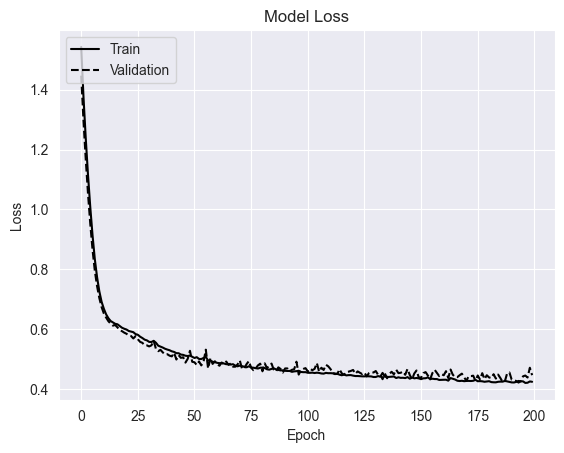

In [31]:
# Plot model loss
plt.plot(history.history["loss"], color="black")
plt.plot(history.history["val_loss"], color="black", linestyle="dashed")
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

<a id='7.2'></a>
## Training/Validation accuracy
The second important quantity to track while training a classifier is the training/validation accuracy. This plot can give us valuable insights into the amount of overfitting in our model. The gap between the trainig and validation accuracy indicates the amount of overfitting.

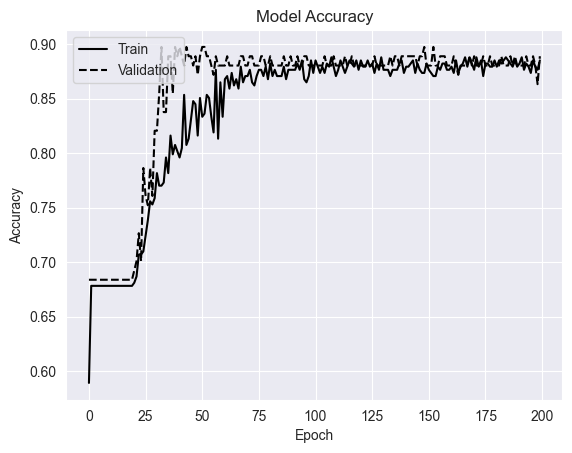

In [32]:
# Plot model accuracy
plt.plot(history.history["accuracy"], color="black")
plt.plot(history.history["val_accuracy"], color="black", linestyle="dashed")
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Train", "Validation"], loc="upper left")
plt.show()

<a id='7.3'></a>
## Accuracy

In [33]:
# Evaluate the model
scores = model.evaluate(X_train, y_train)
print("Training Accuracy: %.2f%%\n" % (scores[1] * 100))
scores = model.evaluate(X_test, y_test)
print("Testing Accuracy: %.2f%%\n" % (scores[1] * 100))

11/11 [==============================] - 0s 3ms/step - loss: 0.4180 - accuracy: 0.8879
Training Accuracy: 88.79%

4/4 [==============================] - 0s 5ms/step - loss: 0.3670 - accuracy: 0.8889
Testing Accuracy: 88.89%



The accuracy is **88.79 %** and **88.89 %** for the training set and the testing set, respectively. The test accuracy of **88.89 %** is quite good for our simple neural network with only one hidden layer. This means that based on the eight readings of a new patient, our model can predict with **~89 %** accuracy whether this patient will develop diabetes within the next five years. The values are also quite close, indicating that the model is unlikely to be over- or underfitting.

<a id='7.4'></a>
## Further improvements
At this point, it is worth asking whether it is possible to further improve the performance of our model. How can we further improve the accuracy of our neural network? In general, performance limitations are due to the lack of meaningful features in the dataset rather than the complexity of the neural network used. The Pima Indian Diabetes dataset consists of only eight features, and it can be argued that eight features alone are not sufficient to truly predict diabetes. One way to increase the number of features we provide to the model is through **feature engineering**. This is a process of using our own expertise about the problem to create new features. However, this can also be a double-edged sword and must be done with care. Adding inappropriate features can disrupt the algorithm and affect the performance of the model. On the other hand, we can also consider removing features to improve the performance of the model. This is called **feature selection**. A popular method for feature selection is the use of decision trees. Although feature engineering and feature selection were not done in this project, this could be a task for the future, so we save our generated model.

In [34]:
# Save the model for later use
model.save("diabetes_detection_model")

INFO:tensorflow:Assets written to: diabetes_detection_model\assets


<a id='8'></a>
# References
1. [Numpy](https://numpy.org/doc/1.24/)
2. [Pandas](https://pandas.pydata.org/docs/)
3. [Tensorflow](https://www.tensorflow.org/versions/r2.10/api_docs/python/tf)
4. [Scikit-Learn](https://scikit-learn.org/stable/modules/classes.html)
5. [Seaborn](https://seaborn.pydata.org/api.html)
6. [Matplotlib](https://matplotlib.org/)
7. [mlxtend](http://rasbt.github.io/mlxtend/USER_GUIDE_INDEX/)
8. [Diagrams](https://www.diagrams.net/)
9. [Dataset](https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database)